#Tea Leaf Disease Classification

* This dataset has been downloaded from kaggle:https://www.kaggle.com/datasets/shashwatwork/identifying-disease-in-tea-leafs.

* The dataset contains classes of seven Common diseases of TeaLeaves.

   * Red leaf spot.

   * Algal leaf spot.

   * Bird’s eyespot.

   * Gray blight.

   * White spot.

   * Anthracnose.

   * Brown blight.





* It also include healthy tea leave classe as well.

* Each of these Classes have  more than 100 images.


#Libraries needed

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
torch.__version__

'2.0.1+cu118'

#Setting up device Agostic code

In [2]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#Mounting Google  Drive

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


#Getting data Ready

In [4]:
from pathlib import Path
import shutil
import zipfile

In [5]:
path=Path("Dataset")
target_path=path/"tea.zip"

path.mkdir(parents=True,exist_ok=True)

source_path="/content/drive/MyDrive/Tea.zip"
print("Copying....")
shutil.copy2(source_path,target_path)



Copying....


PosixPath('Dataset/tea.zip')

In [6]:
with zipfile.ZipFile(target_path) as file:
  file.extractall(path/"Tea")
  print("Extracted")

Extracted


In [7]:
import random
import os

In [8]:
imagepath=path/"Tea/tea sickness dataset"
images=list(imagepath.glob("*/*.jpg"))
len(images)

885

In [9]:
for image in random.sample(images,k=9):
  print(image)


Dataset/Tea/tea sickness dataset/healthy/UNADJUSTEDNONRAW_thumb_223.jpg
Dataset/Tea/tea sickness dataset/brown blight/UNADJUSTEDNONRAW_thumb_137.jpg
Dataset/Tea/tea sickness dataset/gray light/IMG_20220503_141945.jpg
Dataset/Tea/tea sickness dataset/healthy/UNADJUSTEDNONRAW_thumb_208.jpg
Dataset/Tea/tea sickness dataset/white spot/UNADJUSTEDNONRAW_thumb_e8.jpg
Dataset/Tea/tea sickness dataset/healthy/UNADJUSTEDNONRAW_thumb_22c.jpg
Dataset/Tea/tea sickness dataset/algal leaf/UNADJUSTEDNONRAW_thumb_27.jpg
Dataset/Tea/tea sickness dataset/red leaf spot/UNADJUSTEDNONRAW_thumb_188.jpg
Dataset/Tea/tea sickness dataset/red leaf spot/UNADJUSTEDNONRAW_thumb_19f.jpg


In [11]:
count=0
for dirpath,dirnames,files in os.walk(imagepath):
  count+=len(files)
  print(f"There are {len(dirnames)} and files {len(files)} in {dirpath}")

There are 8 and files 0 in Dataset/Tea/tea sickness dataset
There are 0 and files 143 in Dataset/Tea/tea sickness dataset/red leaf spot
There are 0 and files 142 in Dataset/Tea/tea sickness dataset/white spot
There are 0 and files 74 in Dataset/Tea/tea sickness dataset/healthy
There are 0 and files 100 in Dataset/Tea/tea sickness dataset/Anthracnose
There are 0 and files 113 in Dataset/Tea/tea sickness dataset/algal leaf
There are 0 and files 113 in Dataset/Tea/tea sickness dataset/brown blight
There are 0 and files 100 in Dataset/Tea/tea sickness dataset/bird eye spot
There are 0 and files 100 in Dataset/Tea/tea sickness dataset/gray light


In [12]:
count


885

In [13]:
torch.manual_seed(42)

train_len=0.8


In [14]:
!pip install split_folders

In [15]:
import splitfolders

input_folder = imagepath #Enter Input Folder
output = path/"Actual" #Enter Output Folder

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(0.8,0.2))

Copying files: 885 files [00:02, 368.53 files/s]


In [16]:
train_path=output/"train"
test_path=output/"val"
train_path,test_path

(PosixPath('Dataset/Actual/train'), PosixPath('Dataset/Actual/val'))

In [17]:
count=0
for dirpath,dirnames,files in os.walk(test_path):
  count+=len(files)
  print(f"There are {len(dirnames)} and files {len(files)} in {dirpath}")

count

There are 8 and files 0 in Dataset/Actual/val
There are 0 and files 29 in Dataset/Actual/val/red leaf spot
There are 0 and files 29 in Dataset/Actual/val/white spot
There are 0 and files 15 in Dataset/Actual/val/healthy
There are 0 and files 20 in Dataset/Actual/val/Anthracnose
There are 0 and files 23 in Dataset/Actual/val/algal leaf
There are 0 and files 23 in Dataset/Actual/val/brown blight
There are 0 and files 20 in Dataset/Actual/val/bird eye spot
There are 0 and files 20 in Dataset/Actual/val/gray light


179

In [18]:
706+179

885

In [19]:
from PIL import Image


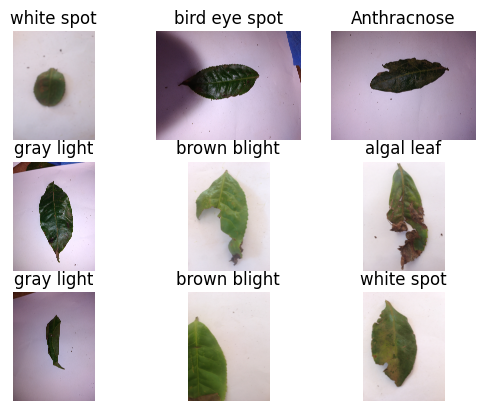

In [20]:
def visualization(data:Path,number_of_images:int):

  images=random.sample(list(data.glob("*/*.jpg",)),k=number_of_images)

  col=number_of_images//3
  for count,image in enumerate(images,start=1):
    plt.subplot(3,col,count)
    plt.imshow(Image.open(image))
    plt.title(image.parent.stem)
    plt.axis("off")
visualization(test_path,9)

#creating dataloaders and datasets

In [21]:
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import EfficientNet_B0_Weights
from torchvision import transforms,datasets

In [22]:
def datasets_dataloaders_creation(train_data_path:Path,
                                  test_data_path:Path,
                                   batchsize:int,
                                  transform:torchvision.transforms=None

                                  ):
  train_dataset=ImageFolder(root=train_data_path,transform =transform)
  test_dataset=ImageFolder(root=test_data_path,transform =transform)


  train_data_loader=DataLoader(dataset=train_dataset,
                               batch_size=batchsize,
                               pin_memory=True,
                               shuffle=True)
  test_data_loader=DataLoader(dataset=test_dataset,
                               batch_size=batchsize,
                               pin_memory=True,
                               shuffle=True)
  return train_data_loader,test_data_loader,train_dataset.classes

In [23]:
!pip install torchinfo

In [24]:
from torchinfo import summary
from torchvision.models import efficientnet_b0

In [25]:
def summary_checker(model,input_size):
   return summary(model,input_size=input_size,col_names=["output_size",
"num_params",
"trainable",])

In [26]:
def train_loop(data:torch.utils.data,
               model:torch.nn,
               loss_fn:torch.nn,
               optimizer:torch.optim,
               accuracy,
               device):
  model.train()

  trainloss,trainaccuracy=0,0
  for x,y in data:
    x,y=x.to(device),y.to(device)
    y_pred=model(x)
    loss=loss_fn(y_pred,y)
    trainloss+=loss
    trainaccuracy+=accuracy(y,torch.argmax(torch.softmax(y_pred,dim=1),dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  return trainloss/len(data),trainaccuracy/len(data)

In [27]:
def test_loop(data:torch.utils.data,
               model:torch.nn,
               loss_fn:torch.nn,
               accuracy,
               device):
  model.eval()
  testloss,testaccuracy=0,0
  with torch.inference_mode():
    for x,y in data:
      x,y=x.to(device),y.to(device)
      y_pred=model(x)
      loss=loss_fn(y_pred,y)
      testloss+=loss
      testaccuracy+=accuracy(y,torch.argmax(torch.softmax(y_pred,dim=1),dim=1))
  return testloss/len(data),testaccuracy/len(data)

In [28]:
def model_building(train_data:torch.utils.data,
                   test_data:torch.utils.data,
                   model:torch.nn,
                   loss_fn:torch.nn,
                   optimizer:torch.optim,
                   accuracy,
                   device,
                   no_of_epochs):

   results={"trainloss":[],
            "trainaccuracy":[],
            "testloss":[],
            "testaccuracy":[]
   }
   model=model.to(device)
   for epoch in range(no_of_epochs):
      print(f"Epoch : {epoch}-------------------------------------------")
      trainloss,trainaccuracy=train_loop(train_data,model,loss_fn,optimizer,accuracy,device)
      testloss,testaccuracy=test_loop(test_data,model,loss_fn,accuracy,device)
      print(f"Trainloss : {trainloss} | TrainAccuracy : {trainaccuracy}  | TestLoss : {testloss}  | TestAccuracy  :{testaccuracy} ")
      results["trainloss"].append(trainloss.item())
      results["trainaccuracy"].append(trainaccuracy.item())
      results["testloss"].append(testloss.item())
      results["testaccuracy"].append(testaccuracy.item())

   return results


In [47]:
##Plotting Loss curves and accuarcy curves

def plotting_loss_curves(results):

  train_loss=results['trainloss']
  test_loss=results['testloss']
  train_accuracy=results['trainaccuracy']
  test_accuracy=results['testaccuracy']
  # epochs
  epoch=range(len(results['trainloss']))
  plt.figure(figsize=(10,7))

  #Loss

  plt.subplot(1,2,1)
  plt.plot(epoch,train_loss,label="Train Loss")
  plt.plot(epoch,test_loss,label="Test Loss")
  plt.title("Loss Curve")
  plt.xlabel("Epochs")
  plt.legend()

  # Accuracy

  plt.subplot(1,2,2)
  plt.plot(epoch,train_accuracy,label="Train Accuracy")
  plt.plot(epoch,test_accuracy,label="Test Accuracy")
  plt.title("Accuracy Curve")
  plt.legend()
  plt.xlabel("Epochs")



#Efficient_model B2

In [29]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 8.1 MB/s eta 0:00:00


In [30]:
from torchmetrics import Accuracy


#Setting up device agnostic code

In [31]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#creating  dataloaders for `Efficient_B0`

In [33]:
from torchvision.models import efficientnet_b0,EfficientNet_B0_Weights
weights=EfficientNet_B0_Weights.DEFAULT
transform=weights.transforms()
transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [34]:
batchsize=32
train_data_loader,test_data_loader,classes=datasets_dataloaders_creation(train_path,test_path,
                                                                         batchsize=batchsize,
                                                                         transform=transform)
len(train_data_loader),len(test_data_loader),classes,len(classes)


(23,
 6,
 ['Anthracnose',
  'algal leaf',
  'bird eye spot',
  'brown blight',
  'gray light',
  'healthy',
  'red leaf spot',
  'white spot'],
 8)

In [35]:
from torch import nn
from torchvision.models import efficientnet_b0

model=efficientnet_b0(weights)
summary_checker(model,[32,3,256,256])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 52.7MB/s]


Layer (type:depth-idx)                                  Output Shape              Param #                   Trainable
EfficientNet                                            [32, 1000]                --                        True
├─Sequential: 1-1                                       [32, 1280, 8, 8]          --                        True
│    └─Conv2dNormActivation: 2-1                        [32, 32, 128, 128]        --                        True
│    │    └─Conv2d: 3-1                                 [32, 32, 128, 128]        864                       True
│    │    └─BatchNorm2d: 3-2                            [32, 32, 128, 128]        64                        True
│    │    └─SiLU: 3-3                                   [32, 32, 128, 128]        --                        --
│    └─Sequential: 2-2                                  [32, 16, 128, 128]        --                        True
│    │    └─MBConv: 3-4                                 [32, 16, 128, 128]        1,448      

In [36]:
for param in model.features.parameters():
  param.requires_grad=False

In [37]:
summary_checker(model,[32,3,256,256])

Layer (type:depth-idx)                                  Output Shape              Param #                   Trainable
EfficientNet                                            [32, 1000]                --                        Partial
├─Sequential: 1-1                                       [32, 1280, 8, 8]          --                        False
│    └─Conv2dNormActivation: 2-1                        [32, 32, 128, 128]        --                        False
│    │    └─Conv2d: 3-1                                 [32, 32, 128, 128]        (864)                     False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 128, 128]        (64)                      False
│    │    └─SiLU: 3-3                                   [32, 32, 128, 128]        --                        --
│    └─Sequential: 2-2                                  [32, 16, 128, 128]        --                        False
│    │    └─MBConv: 3-4                                 [32, 16, 128, 128]        (1,

In [38]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [39]:
model.classifier=nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280,out_features=len(classes),bias=True)
)

In [40]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=8, bias=True)
)

In [41]:
accuracy=Accuracy(task="multiclass",num_classes=len(classes)).to(device)

loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=0.1)
results=model_building(train_data_loader,
                       test_data_loader,
                       model,
                       loss_fn,
                       optimizer,
                       accuracy,
                       device,
                       5)

Epoch : 0-------------------------------------------
Trainloss : 1.4414002895355225 | TrainAccuracy : 0.5054348111152649  | TestLoss : 1.2582297325134277  | TestAccuracy  :0.5375548601150513 
Epoch : 1-------------------------------------------
Trainloss : 0.8989387154579163 | TrainAccuracy : 0.720108687877655  | TestLoss : 1.3731467723846436  | TestAccuracy  :0.43804824352264404 
Epoch : 2-------------------------------------------
Trainloss : 0.711645245552063 | TrainAccuracy : 0.770380437374115  | TestLoss : 0.7735738158226013  | TestAccuracy  :0.7354714870452881 
Epoch : 3-------------------------------------------
Trainloss : 0.5809029936790466 | TrainAccuracy : 0.842391312122345  | TestLoss : 0.7057520747184753  | TestAccuracy  :0.7563048601150513 
Epoch : 4-------------------------------------------
Trainloss : 0.5348018407821655 | TrainAccuracy : 0.8586956858634949  | TestLoss : 0.6548652648925781  | TestAccuracy  :0.7390351295471191 


In [42]:
results

{'trainloss': [1.4414002895355225,
  0.8989387154579163,
  0.711645245552063,
  0.5809029936790466,
  0.5348018407821655],
 'trainaccuracy': [0.5054348111152649,
  0.720108687877655,
  0.770380437374115,
  0.842391312122345,
  0.8586956858634949],
 'testloss': [1.2582297325134277,
  1.3731467723846436,
  0.7735738158226013,
  0.7057520747184753,
  0.6548652648925781],
 'testaccuracy': [0.5375548601150513,
  0.43804824352264404,
  0.7354714870452881,
  0.7563048601150513,
  0.7390351295471191]}

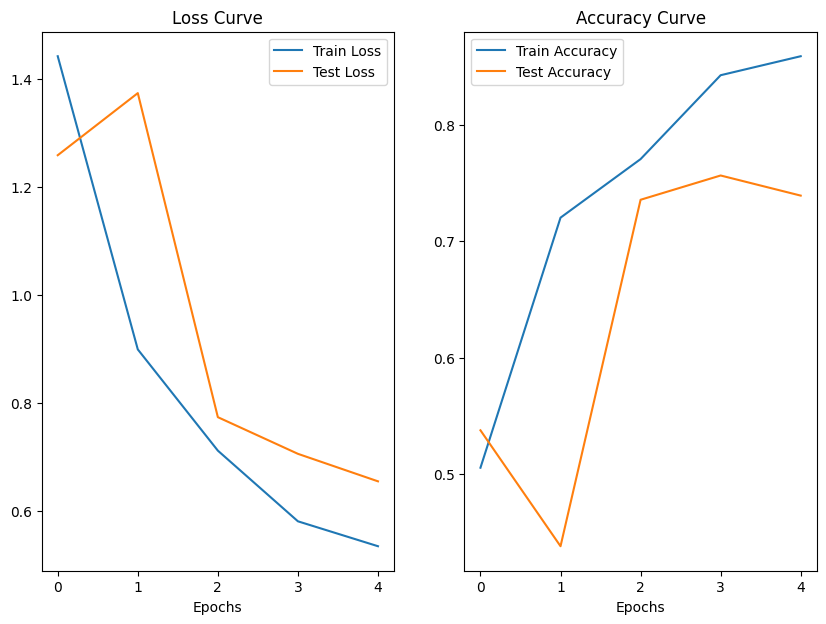

In [48]:
plotting_loss_curves(results)

#Googlenet

In [52]:
from torchvision.models import googlenet,GoogLeNet_Weights

##Downloading weights for model

In [53]:
weights_gnet=GoogLeNet_Weights.DEFAULT
transforms_gnet=weights_gnet.transforms()
transforms_gnet

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

##Creating dataset and dataloader for model

In [56]:
train_data_loader_gnet,test_data_loader_gnet,classes=datasets_dataloaders_creation(train_data_path=train_path,
                                                                                   test_data_path=test_path,
                                                                                   batchsize=32,
                                                                                   transform=transforms_gnet,)
len(train_data_loader_gnet),len(test_data_loader_gnet),classes

(23,
 6,
 ['Anthracnose',
  'algal leaf',
  'bird eye spot',
  'brown blight',
  'gray light',
  'healthy',
  'red leaf spot',
  'white spot'])

##Creating model instance


In [88]:
model_gnet=googlenet(weights_gnet)
model_gnet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [89]:
summary_checker(model_gnet,[32,3,256,256])

Layer (type:depth-idx)                   Output Shape              Param #                   Trainable
GoogLeNet                                [32, 1000]                --                        True
├─BasicConv2d: 1-1                       [32, 64, 128, 128]        --                        True
│    └─Conv2d: 2-1                       [32, 64, 128, 128]        9,408                     True
│    └─BatchNorm2d: 2-2                  [32, 64, 128, 128]        128                       True
├─MaxPool2d: 1-2                         [32, 64, 64, 64]          --                        --
├─BasicConv2d: 1-3                       [32, 64, 64, 64]          --                        True
│    └─Conv2d: 2-3                       [32, 64, 64, 64]          4,096                     True
│    └─BatchNorm2d: 2-4                  [32, 64, 64, 64]          128                       True
├─BasicConv2d: 1-4                       [32, 192, 64, 64]         --                        True
│    └─Conv2d: 2-

##setting the features parameter to false for not tracking any gradients

In [90]:
for param in model_gnet.parameters():
  param.requires_grad=False

In [71]:
model_gnet.fc# the model pointing to

Linear(in_features=1024, out_features=1000, bias=True)

In [91]:
model_gnet.fc=nn.Linear(
    in_features=1024, out_features=len(classes), bias=True

)

In [92]:
model_gnet.fc# the model pointing to

Linear(in_features=1024, out_features=8, bias=True)

In [95]:
for param in model_gnet.fc.parameters():
  param.requires_grad=True

In [96]:
summary_checker(model_gnet,[32,3,256,256])

Layer (type:depth-idx)                   Output Shape              Param #                   Trainable
GoogLeNet                                [32, 8]                   --                        Partial
├─BasicConv2d: 1-1                       [32, 64, 128, 128]        --                        False
│    └─Conv2d: 2-1                       [32, 64, 128, 128]        (9,408)                   False
│    └─BatchNorm2d: 2-2                  [32, 64, 128, 128]        (128)                     False
├─MaxPool2d: 1-2                         [32, 64, 64, 64]          --                        --
├─BasicConv2d: 1-3                       [32, 64, 64, 64]          --                        False
│    └─Conv2d: 2-3                       [32, 64, 64, 64]          (4,096)                   False
│    └─BatchNorm2d: 2-4                  [32, 64, 64, 64]          (128)                     False
├─BasicConv2d: 1-4                       [32, 192, 64, 64]         --                        False
│    └─

##model building

In [100]:
#batchsize and accuracy
batchsize=32
accuracy=Accuracy(task="multiclass",num_classes=len(classes)).to(device)


#setting up loss function and optimizer

loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model_gnet.parameters(),lr=0.1)

##model Building

results=model_building(train_data=train_data_loader_gnet,
                       test_data=test_data_loader_gnet,
                       model=model_gnet,
                       optimizer=optimizer,
                       accuracy=accuracy,
                       device=device,
                       no_of_epochs=5,loss_fn=loss_fn)

Epoch : 0-------------------------------------------
Trainloss : 20.03727149963379 | TrainAccuracy : 0.29076087474823  | TestLoss : 3.967933177947998  | TestAccuracy  :0.5792214870452881 
Epoch : 1-------------------------------------------
Trainloss : 3.939932107925415 | TrainAccuracy : 0.63451087474823  | TestLoss : 5.215538024902344  | TestAccuracy  :0.612390398979187 
Epoch : 2-------------------------------------------
Trainloss : 4.728257179260254 | TrainAccuracy : 0.6195652484893799  | TestLoss : 2.605280876159668  | TestAccuracy  :0.7165570259094238 
Epoch : 3-------------------------------------------
Trainloss : 2.012657642364502 | TrainAccuracy : 0.7527173757553101  | TestLoss : 4.278714179992676  | TestAccuracy  :0.6609101295471191 
Epoch : 4-------------------------------------------
Trainloss : 2.044403076171875 | TrainAccuracy : 0.7839674353599548  | TestLoss : 2.72324800491333  | TestAccuracy  :0.721491277217865 


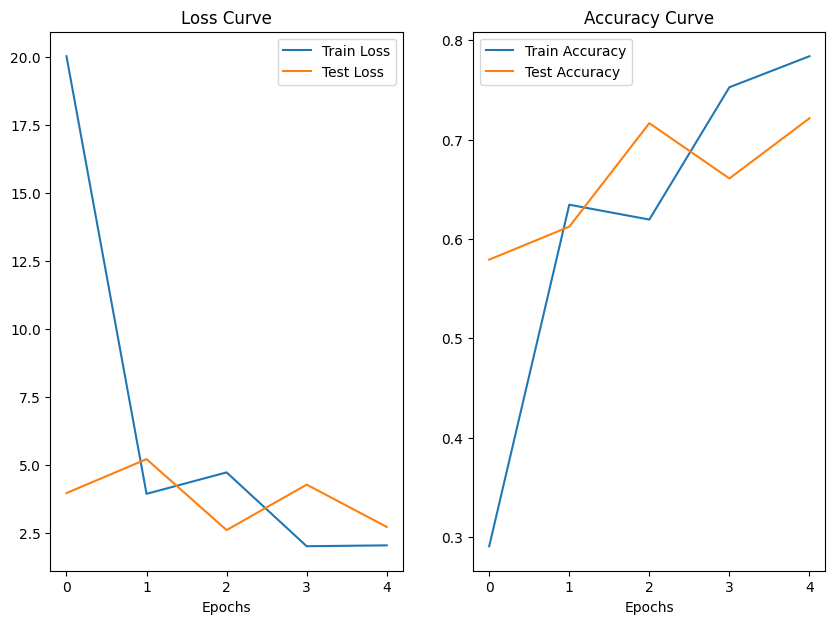

In [101]:
plotting_loss_curves(results)

##Among these models Efficientnet b0 performs better
 * Increase iterations for efficient net b0

In [105]:
from torchvision.models import efficientnet_b0,EfficientNet_B0_Weights
def model_efficientnet(train_path,test_path,batchsize):
  weights=EfficientNet_B0_Weights.DEFAULT
  transform=weights.transforms()
  batchsize=32
  train_data_loader,test_data_loader,classes=datasets_dataloaders_creation(train_path,test_path,
                                                                         batchsize=batchsize,
                                                                         transform=transform)
  model=efficientnet_b0(weights)
  for param in model.features.parameters():
    param.requires_grad=False

  model.classifier=nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280,out_features=len(classes),bias=True)
  )
  return train_data_loader,test_data_loader,classes,model

In [106]:
accuracy=Accuracy(task="multiclass",num_classes=len(classes)).to(device)
batchsize=32
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=0.1)
train_data_loader,test_data_loader,classes,model_eff=model_efficientnet(train_path,test_path,batchsize)
results=model_building(train_data_loader,
                       test_data_loader,
                       model,
                       loss_fn,
                       optimizer,
                       accuracy,
                       device,
                       10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Epoch : 0-------------------------------------------
Trainloss : 0.4560050368309021 | TrainAccuracy : 0.8600543737411499  | TestLoss : 0.7417242527008057  | TestAccuracy  :0.7236842513084412 
Epoch : 1-------------------------------------------
Trainloss : 0.4382026195526123 | TrainAccuracy : 0.866847813129425  | TestLoss : 0.5956692695617676  | TestAccuracy  :0.8070175647735596 
Epoch : 2-------------------------------------------
Trainloss : 0.43179669976234436 | TrainAccuracy : 0.8804348111152649  | TestLoss : 0.6459086537361145  | TestAccuracy  :0.7423245906829834 
Epoch : 3-------------------------------------------
Trainloss : 0.4195076525211334 | TrainAccuracy : 0.8817934989929199  | TestLoss : 0.6815714836120605  | TestAccuracy  :0.7478070259094238 
Epoch : 4-------------------------------------------
Trainloss : 0.439303457736969 | TrainAccuracy : 0.8709239363670349  | TestLoss : 0.6911147832870483  | TestAccuracy  :0.7357456088066101 
Epoch : 5--------------------------------

In [107]:
results

{'trainloss': [0.4560050368309021,
  0.4382026195526123,
  0.43179669976234436,
  0.4195076525211334,
  0.439303457736969,
  0.36798813939094543,
  0.304225891828537,
  0.3110004663467407,
  0.36709409952163696,
  0.2800379991531372],
 'trainaccuracy': [0.8600543737411499,
  0.866847813129425,
  0.8804348111152649,
  0.8817934989929199,
  0.8709239363670349,
  0.89673912525177,
  0.936141312122345,
  0.9307065606117249,
  0.904891312122345,
  0.914402186870575],
 'testloss': [0.7417242527008057,
  0.5956692695617676,
  0.6459086537361145,
  0.6815714836120605,
  0.6911147832870483,
  0.5438194274902344,
  0.5557427406311035,
  0.6093329191207886,
  0.5531935691833496,
  0.618187665939331],
 'testaccuracy': [0.7236842513084412,
  0.8070175647735596,
  0.7423245906829834,
  0.7478070259094238,
  0.7357456088066101,
  0.7809759378433228,
  0.7913925647735596,
  0.7966009378433228,
  0.7946820259094238,
  0.7982456088066101]}

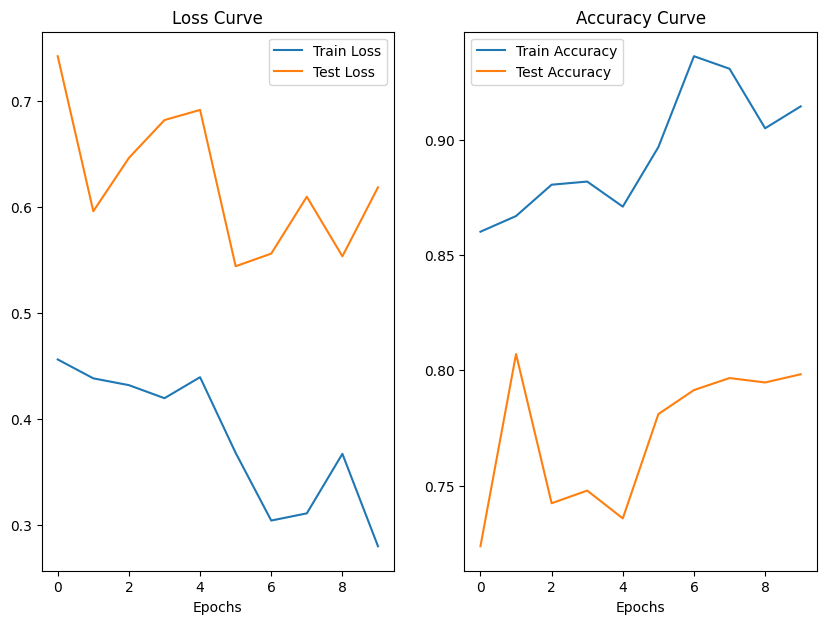

In [108]:
plotting_loss_curves(results)

##predictions on random test samples

In [117]:
def make_predictions(model,
                     data,
                     device):
  pred_labels=[]
  model=model.to(device)
  for sample in data:
    sample=sample.to(device)
    y_pred=model(sample.unsqueeze(0))
    pred_labels.append(y_pred.squeeze().argmax(dim=0).item())
  return pred_labels


In [145]:
import random
test_samples=[]
test_labels=[]
test_dataset=ImageFolder(root=test_path,transform =transform)
for sample,label in random.sample(list(test_dataset),k=9):
  test_samples.append(sample)
  test_labels.append(label)
test_samples[0].shape

torch.Size([3, 224, 224])

In [146]:
pred_labels=make_predictions(model,test_samples,device)
pred_labels

[6, 1, 7, 6, 6, 1, 3, 6, 7]

In [147]:
test_labels

[6, 1, 7, 6, 6, 1, 3, 6, 7]

#Visualize the result

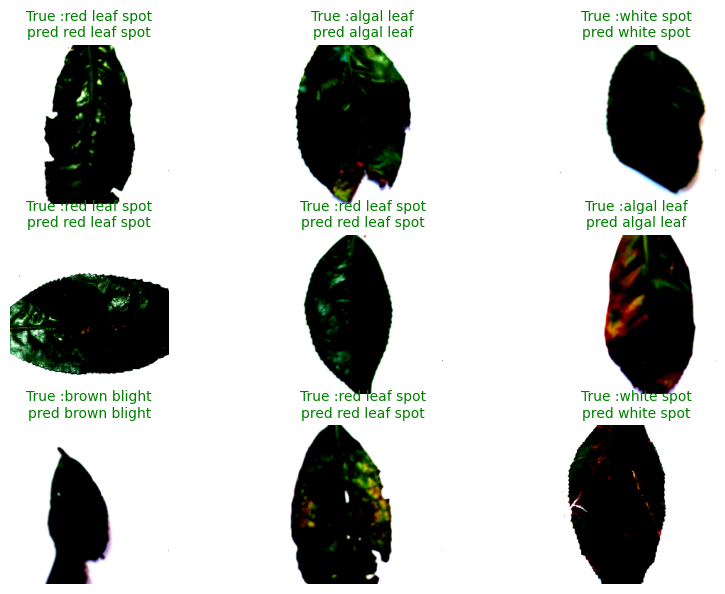

In [148]:
plt.figure(figsize=(10,7))

col,row=3,3

for i,sample in enumerate(test_samples,start=1):
  plt.subplot(col,row,i)
  plt.imshow(sample.permute(1,2,0))

  pred_label=pred_labels[i-1]
  true_label=test_labels[i-1]
  if(pred_label==true_label):

     plt.title(f"True :{classes[true_label] }\npred {classes[pred_label]}",fontsize=10,c='g')
  else:
    plt.title(f"True :{classes[true_label] }\npred {classes[pred_label]}",fontsize=10,c='r')
  plt.axis("off")



#saving model

In [149]:
from pathlib import Path
path=Path("Models")
path.mkdir(parents=True,exist_ok=True)
efficient_net_path=path/"EFFICIENT_NET_B0.pth"
torch.save(obj=model.state_dict(),f=efficient_net_path)

In [150]:
model_saved=efficientnet_b0(weights)
for param in model_saved.features.parameters():
  param.requires_grad=False
model_saved.classifier=nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280,out_features=8,bias=True)
)
model_saved.load_state_dict(torch.load(efficient_net_path))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


<All keys matched successfully>